In [ ]:
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install gensim

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/docs/*
    /usr/local/lib/python3.7/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.7/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl


In [ ]:
# imports

import numpy as np
import pandas as pd
import keras
import os
from math import nan
from keras.callbacks import ModelCheckpoint
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import keras as k
print(k.__version__)
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

import time
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from future.utils import iteritems
from sklearn.metrics import classification_report
from gensim.models import Word2Vec, FastText
from keras.preprocessing.text import Tokenizer

from keras_contrib.layers import CRF
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras.models import load_model
import re

from google.colab import drive
drive.mount('/content/drive')


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-lapo4yev
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-lapo4yev
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=d7a59227e3d24683732cd657c1d14733662578a5fad2b7b590954372dcb3e33d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qeex7qg/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
2.2.4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
max_len_seq = ...
vocabulary = ...
number_of_words = ...
number_of_tags = ...
tags = ...
word_to_ids = ...
tag_to_ids = ...
ids_to_tags = ...

TP = {}
TN = {}
FP = {}
FN = {}

def get_path(*args):
    spec_path = os.sep.join(args)
    return os.path.join(os.getcwd(), spec_path)

# read file and create data frame from it
def parse_data(will_parsed_row_of_corpus):

  file_path = get_path("drive","MyDrive","TWNERTC_TC_Coarse Grained NER_DomainIndependent_NoiseReduction.DUMP") 

  f = open(file_path, "r")

  line_count = 0

  data = dict()
  data["sentence_id"] = list()
  data["tag"] = list()
  data["word"] = list()

  sentence_id_arr = data["sentence_id"]
  tag_arr = data["tag"]
  word_arr = data["word"]


  for line in f.readlines():

    if line_count > will_parsed_row_of_corpus:
      break

    line_count += 1
    # each line seperated by ht (horizontal tabs)
    splitted = line.split("\t")
    
    if len(splitted) ==3:
      tag_split = splitted[1].split(" ")
      word_split = splitted[2].split(" ")
    
      for tag, word in zip(tag_split, word_split):
          word = word.lower()
          word = word.strip()
          if word[len(word)-1] == "\n":
              word = word[:-1]
          
          sentence_id_arr.append(line_count)
          tag_arr.append(tag)
          word_arr.append(word)

  df = pd.DataFrame(data, columns=["sentence_id", "tag", "word"])

  print(df.head())
  print(f"data shape -> {df.shape[0]}")

  return df

class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None



def analyze_and_preprocess(df, test_size=0.2):
  global max_len_seq, vocabulary, number_of_words, number_of_tags, tags, word_to_ids, tag_to_ids, ids_to_tags
  
  # creating sentence sequences with tags from data (preprocess)
  sentences = SentenceGetter(df).sentences
  print(f"Number of sentences in data set {len(sentences)}")
  print(sentences[10])

  # it should be static because when we split for just testing max length might be different
  # and it will produce error while padding and test will not be finish correctly 
  # I set it 100 because in TBMM corpus there might be longer sentences than this corpus includes.
  max_len_seq = 100

  # plot lengths of sequences (sentences) graph
  plt.hist([len(s) for s in sentences], bins=max_len_seq)
  plt.show()
  # create set of unique words and add ENDPAD as last element
  vocabulary = list(set(df["word"].values))
  vocabulary.append("ENDPAD")

  number_of_words = len(vocabulary) 
  print(f"Number of unique words (Vocabulay size) -> {number_of_words}")

  # create set of unique tags
  tags = list(set(df["tag"].values))
  print("Tags ->", tags)

  number_of_tags = len(tags)
  print(f"Number of tags -> {number_of_tags}") 

  # creating index dictionaries for words and tags
  word_to_ids = {w: i for i, w in enumerate(vocabulary)}
  tag_to_ids = {t: i for i, t in enumerate(tags)}
  ids_to_tags = {v: k for k, v in iteritems(tag_to_ids)}

  # fill with padding value (ENDPAD) until being equal all sequence size with longest sequence
  X = [[word_to_ids[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len_seq, sequences=X, padding="post",value=number_of_words - 1)

  # fill with padding value (O) until being equal all sequence size with longest sequence
  y_id = [[tag_to_ids[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len_seq, sequences=y_id, padding="post", value=tag_to_ids["O"])
  print(f"Lenght of y[0] -> {len(y[0])}") # it should be equal longest sentence length

  y = [to_categorical(i, num_classes=number_of_tags) for i in y]

  # split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  return X_train, X_test, y_train, y_test, vocabulary, tags

def get_word2vec_embeddding_layer(embedding_size, num_words,input_shape):
    global vocabulary
    tokenizer = Tokenizer()
    # Train Word2Vec model with gensim on the dataset
    w2v_model = Word2Vec(vocabulary, size=embedding_size, workers=8)

    embedding_matrix_w2v = np.random.random(((num_words)+1, embedding_size))
    for word,i in tokenizer.word_index.items():  
      try:
          embedding_matrix_w2v[i] = w2v_model.wv[word]
      except:
          pass

    # create layer
    embedding_layer_w2v = Embedding(num_words+1, output_dim=embedding_size, weights=[embedding_matrix_w2v], input_length=input_shape, trainable=True)

    return embedding_layer_w2v

# input shape should be equal to the longest input length
def prepare_model( embedding_spec=0):
  
  max_len = 
  embedding_size = 300
  learning_rate = 0.01

  input = Input(shape=(200,))

  if embedding_spec == 0: # for keras embeddding
      embedding = Embedding(input_dim=num_words, output_dim=embedding_size, input_length=input_shape)
        
      
  model = embedding(input)
  model = Bidirectional(LSTM(units=embedding_size, 
                          return_sequences=True, 
                          dropout=0.5, 
                          recurrent_dropout=0.5, 
                          kernel_initializer=k.initializers.he_normal()))(model)
  model = LSTM(units=embedding_size * 2, 
              return_sequences=True, 
              dropout=0.5, 
              recurrent_dropout=0.5, 
              kernel_initializer=k.initializers.he_normal())(model)
  model = TimeDistributed(Dense(num_tags, activation="relu"))(model)  # previously softmax output layer

  crf = CRF(num_tags)  # CRF layer
  out = crf(model)  # output

  model = Model(input, out)

  adam = k.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
  #model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  
  return model

# model evaluation metrics
def set_dafault_evaluation_parameters():
  global TP, FN, FP, TN
  for tag in tag_to_ids.keys():
      TP[tag] = 0
      TN[tag] = 0    
      FP[tag] = 0    
      FN[tag] = 0    


def accumulate_score_by_tag(gt, pred):
  global TP, FN, FP, TN
  """
  For each tag keep stats
  """
  if gt == pred:
      TP[gt] += 1
  elif gt != 'O' and pred == 'O':
      FN[gt] +=1
  elif gt == 'O' and pred != 'O':
      FP[gt] += 1
  else:
      TN[gt] += 1

# Single prediction and verbose results
def predict_single_sequence(model, sequence, X_test, y_test):
  global vocabulary, ids_to_tags, tags
  i = 10
  p = model.predict(np.array(sequence))
  p = np.argmax(p, axis=-1)
  gt = np.argmax(y_test[i], axis=-1)
  print(gt)
  print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
  for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
      #
      print("{:14}: ({:5}): {}".format(vocabulary[w],ids_to_tags[gt[idx]],tags[pred]))

def test_model(model,X_test,y_test):
  global ids_to_tags, tags, tag_to_ids, TN, FP, FN, TP

  p = model.predict(np.array(X_test))
  print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(ids_to_tags.keys()), target_names=list(ids_to_tags.values())))
  
  # acumulate the scores by tag
  for i, sentence in enumerate(X_test):
      y_hat = np.argmax(p[i], axis=-1)
      gt = np.argmax(y_test[i], axis=-1)
      for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
          accumulate_score_by_tag(ids_to_tags[gt[idx]],tags[pred])

  for tag in tag_to_ids.keys():
      print(f'tag:{tag}')    
      print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
      print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))  

# Saving the best only
def train_model(model):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=[early_stopping])
  return history, model

def save_model(model, *attr):
  file_name = "ner_model_with_params_"+"_".join(attr)+".h5"
  file_path = get_path(file_name)
  model.save(file_path)

def load_model_from_save(model_file_name):
  return load_model(model_file_name,custom_objects={'CRF':CRF, 'crf_loss':crf_loss, 'crf_viterbi_accuracy':crf_viterbi_accuracy})

def test_wiht_single_sentence(model, sentence, max_len_seq):
  
  sentence = sentence.lower()
  revised_sentence = ""
  punc_set = set([',',':',';','"','(',')','[',']',';','!']) # set('!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~')
  for character in sentence:
    if character in punc_set:
      revised_sentence += " " + character
    else:
      revised_sentence += character

  words = sentence.split(" ")
  words_arr = [[word] for word in words ]
  len_words = len(words)

  for i in range(len_words, max_len_seq):
    words.append("ENDPAD")

  words = np.asmatrix(words).T
  print(words.shape)
  p = model.predict(words)
  p = np.argmax(p, axis=-1)

  res = []
  for word, prediction in zip(words, p[0]):
    res.append(f"{word} -> {prediction}")
  
  res_str = " ".join(res)


   sentence_id         tag      word
0            1    B-PERSON    corina
1            1    I-PERSON  casanova
2            1           O         ,
3            1  B-LOCATION  i̇sviçre
4            1           O   federal
data shape -> 1744
Number of sentences in data set 101
[('denton', 'B-LOCATION'), (',', 'O'), ('amerika', 'B-LOCATION'), ('birleşik', 'I-LOCATION'), ("devletleri'nde", 'I-LOCATION'), ('teksas', 'B-LOCATION'), ('eyaletinin', 'O'), ('denton', 'B-LOCATION'), ('bölgesindeki', 'O'), ('bir', 'O'), ('şehirdir', 'O'), ('.', 'O')]


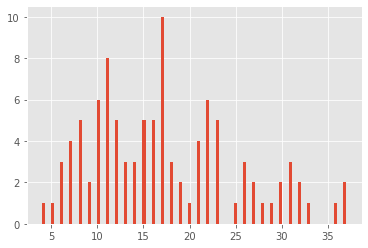

Number of unique words (Vocabulay size) -> 975
Tags -> ['B-MISC', 'B-LOCATION', 'B-PERSON', 'B-ORGANIZATION', 'I-PERSON', 'O', 'I-LOCATION', 'I-ORGANIZATION', 'I-MISC']
Number of tags -> 9
Lenght of y[0] -> 100
(21, 100)


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 300)          292500    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 600)          1442400   
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 600)          2882400   
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 9)            5409      
_________________________________________________________________
crf_8 (CRF)                  (None, 100, 9)            189       
Total params: 4,622,898
Trainable params: 4,622,898
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored

In [ ]:
# train model and test
# parsing data
df = parse_data(100)
# data preprocess and splitting
X_train, X_test, y_train, y_test, vocabulary, tags = analyze_and_preprocess(df)
print(X_test.shape)
# model compreparing (compiling)
embedding_spec = 0 # keras : 0, word2vec : 1
model = prepare_model(len(vocabulary), len(tags), embedding_spec)
model.summary()
# model training
train_model(model)
# saving model
save_model(model, str(100), str(embedding_size), str(learning_rate), str(number_of_words), str(embedding_spec))
# model testing
set_dafault_evaluation_parameters()
# test model
test_model(model,X_test,y_test)

In [ ]:
# reload model and test
# ! set number of rows correctly same with trained model
# parsing data
df = parse_data(100)
# data preprocess and splitting to create test data
X_train, X_test, y_train, y_test, vocabulary, tags = analyze_and_preprocess(df, test_size=0.9)
# load model from pickle file
model= load_model_from_save("ner_model_with_params_50_300_0.01_39953_0.h5")
# set evaluation metrics default
set_dafault_evaluation_parameters()
# test model
test_model(model,X_test,y_test)


In [ ]:

def process_test_data(data, vocabulary, tags, maxlen=200):
  print(vocabulary)
  word_to_ids = {w: i for i, w in enumerate(vocabulary)}
  tag_to_ids = {t: i for i, t in enumerate(tags)}
  ids_to_tags = {v: k for k, v in iteritems(tag_to_ids)}
  X = [[word_to_ids[w.lower()] for w in s.split()] for s in data]
  X = pad_sequences(maxlen=max_len_seq, sequences=X, padding="post",value=number_of_words - 1)
  return X, tag_to_ids, ids_to_tags

In [ ]:
model= load_model_from_save("ner_model_with_params_100_300_0.01_975_0.h5")

NameError: ignored

In [ ]:
test_wiht_single_sentence(model, "Ben ilker Fener, Marmara Üniversitesi'nde Bilgisayar Mühendisliği 4. sınıf öğrencisiyim.", 100)

(100, 1)


ValueError: ignored